In [2]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget
import os
from scipy.signal import savgol_filter
from scipy.optimize import root
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib import ticker

In [3]:
fontsize_legend = 20
fontsize_axes = 24
fontsize_ticks = 16
linewidth_all = 3
markersize_all = 8
size_extra = 4

figsize_whole = (6,5)
figsize_three = (15,5)
figsize_three_vert = (6, 13)
figsize_two = (10,5)
folder_out = 'figures_paper'

color_2folds = 'palevioletred'
color_3folds = 'firebrick'
color_4folds = 'steelblue'

def smooth_pv_data(pressure, window_len = 100):
    # window_len = 100
    poly_order = 2
    len_pressure, num_exp = np.shape(pressure)

    pressure_smooth = np.zeros((len_pressure, num_exp))

    for i in range(num_exp):
        pressure_smooth[:,i] = savgol_filter(pressure[:,i], window_len, poly_order)
    
    return pressure_smooth

def rescale_eigenvalue(eigenvalues_cur):
    return np.sign(eigenvalues_cur) * np.sqrt(np.abs(eigenvalues_cur)) * 1/(2*np.pi)

def highlight_mode(freq_all, initial_i, initial_j, num_samp):
    j_all = np.zeros(np.shape(freq_all)[0], dtype = int)
    i_all = np.arange(np.shape(freq_all)[0], dtype = int)
    j_all[initial_i[0]:initial_i[1] + 1] = initial_j
    cut_idx = initial_i[0] + np.arange(num_samp)

    for idx in range(num_samp):
        i_next = idx + initial_i[1] + 1
        i_cur = [i_next-2,i_next-1]
        j_cur = [j_all[i] for i in i_cur]

        vals_cur = np.array([freq_all[i,j] for i,j in zip(i_cur, j_cur)])
        val_new_est = vals_cur[-1] + np.diff(vals_cur)
        j_all[i_next] = np.argmin(np.abs(freq_all[i_next,:] - val_new_est))
    return (i_all, j_all, cut_idx)


In [4]:
np.asarray(mcolors.to_rgb(mcolors.CSS4_COLORS[color_3folds]))*255
mcolors.CSS4_COLORS[color_4folds]

'#4682B4'

In [5]:
def find_n(R,t,H):
    v1 = R/float(H)
    v2 = t/float(R)
    print(f'({(v2*v1):.3f}, {v1:.3f})')
    nu = 0.5

    n_all = [2,3,4,5,6]

    p_cr = lambda n: ((np.pi*v1)**2 + n**2)**2 * v2**3 / (12 * (1-nu**2) * n**2) + (np.pi*v1)**4 * v2/(n**2 * ((np.pi*v1)**2 + n**2)**2)

    p_cr_all = [p_cr(n) for n in n_all]
    return np.argmin(p_cr_all) + 2


def find_n_alt(v_R, v_t):
    v1 = v_R
    v2 = v_t / v_R
    print(v2)
    # print(f'({v1:.3f},{v2:.3f})')
    nu = 0.5

    n_all = [2,3,4,5,6]

    p_cr = lambda n: ((np.pi*v1)**2 + n**2)**2 * v2**3 / (12 * (1-nu**2) * n**2) + (np.pi*v1)**4 * v2/(n**2 * ((np.pi*v1)**2 + n**2)**2)
    

    p_cr_all = [p_cr(n) for n in n_all]
    return n_all[np.argmin(p_cr_all)]

def find_pcr_n_alt(v_R, v_t):
    v1 = v_R
    v2 = v_t / v_R
    # print(f'({v1:.3f},{v2:.3f})')
    nu = 0.5

    n_all = [2,3,4,5,6]

    p_cr = lambda n: ((np.pi*v1)**2 + n**2)**2 * v2**3 / (12 * (1-nu**2) * n**2) + (np.pi*v1)**4 * v2/(n**2 * ((np.pi*v1)**2 + n**2)**2)

    p_cr_all = [p_cr(n) for n in n_all]
    idx_min = np.argmin(p_cr_all)
    return (n_all[idx_min], p_cr_all[idx_min])



In [6]:
num_try_R = 400
num_try_t = 400

n_all = np.zeros((num_try_R, num_try_t), dtype = int)
p_cr_all = np.zeros((num_try_R, num_try_t))

v_R_try = np.linspace(0.1,0.6, num_try_R)
v_t_try = np.linspace(0.01,0.05, num_try_t)

for i,v_R in enumerate(v_R_try):
    for j,v_t in enumerate(v_t_try):
        n_cur, p_cr_cur = find_pcr_n_alt(v_R, v_t)
        n_all[i,j] = int(n_cur)
        p_cr_all[i,j] = p_cr_cur

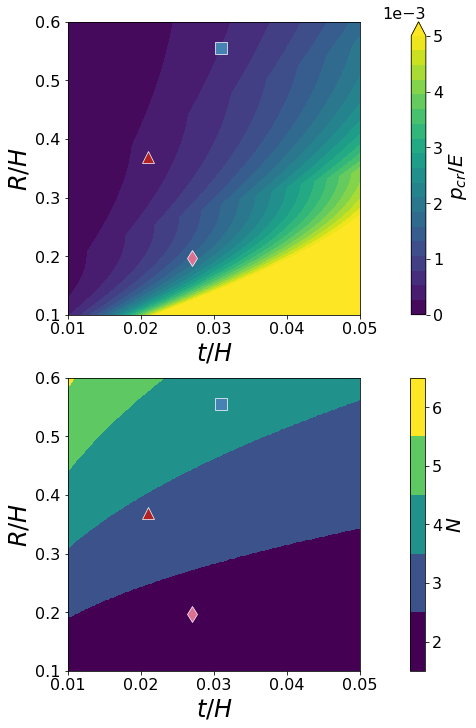

In [24]:
fig, ax = plt.subplots(2,1, figsize = (6.5,10), constrained_layout = True)

edge_width_all = 0.7
cmap_use = 'viridis'
# ax.imshow(res_all)
ax[0].plot(0.031, 0.556, 's', color = 'w', markerfacecolor = color_4folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[0].plot(0.027, 0.197, 'd', color = 'w', markerfacecolor = color_2folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[0].plot(0.021, 0.370, '^', color = 'w', markerfacecolor = color_3folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
num_values = np.unique(n_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')
levels_set = np.linspace(0,0.005,20)
map_thing = ax[0].contourf(yv, xv, p_cr_all, levels = levels_set, cmap = cmap_use, extend = 'max')



cbar = fig.colorbar(map_thing, extend = 'max', ticks=[0, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3], pad = 0.015)
cbar.set_label(label = '$p_{cr}/E$', size = fontsize_legend)
cbar.ax.ticklabel_format(scilimits = (-2,3))
cbar.ax.tick_params(labelsize=fontsize_ticks)
cbar.ax.yaxis.offsetText.set_fontsize(fontsize_ticks)

############################

ax[1].plot(0.031, 0.556, 's', color = 'w', markerfacecolor = color_4folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[1].plot(0.027, 0.197, 'd', color = 'w', markerfacecolor = color_2folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[1].plot(0.021, 0.370, '^', color = 'w', markerfacecolor = color_3folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
num_values = np.unique(n_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')
levels_set = np.arange(6) + 1.5
map_thing = ax[1].contourf(yv, xv, n_all, levels = levels_set, cmap = cmap_use, vmin = 2, vmax = 6)



cbar = fig.colorbar(map_thing, ticks=[2,3,4,5,6], pad = 0.11)
cbar.ax.tick_params(labelsize=fontsize_ticks)
cbar.set_label(label = '$N$', size = fontsize_legend)

for axis in ax:
    axis.set_xlabel('$t/H$', fontsize = fontsize_axes)
    axis.set_ylabel('$R/H$', fontsize = fontsize_axes)
    axis.tick_params(labelsize = fontsize_ticks)
    axis.set_xlim(np.min(v_t_try), np.max(v_t_try))
    axis.set_ylim(np.min(v_R_try), np.max(v_R_try))


fig.savefig(f'{folder_out}/fig1_model_linspace.png', dpi = 300)

In [25]:
E = 1.1

n, p_cr = find_pcr_n_alt(v_t = 0.027, v_R = 0.197)
print(f'{n} folds: p_cr/E = {p_cr:.3e}, p_cr = {p_cr*1e3*E:.3} kPa')

n, p_cr = find_pcr_n_alt(v_t = 0.021, v_R = 0.370)
print(f'{n} folds: p_cr/E = {p_cr:.3e}, p_cr = {p_cr*1e3*E:.3} kPa')

n, p_cr = find_pcr_n_alt(v_R = 0.556, v_t = 0.031)
print(f'{n} folds: p_cr/E = {p_cr:.3e}, p_cr = {p_cr*1e3*E:.3} kPa')

2 folds: p_cr/E = 1.636e-03, p_cr = 1.8 kPa
3 folds: p_cr/E = 3.493e-04, p_cr = 0.384 kPa
4 folds: p_cr/E = 5.262e-04, p_cr = 0.579 kPa


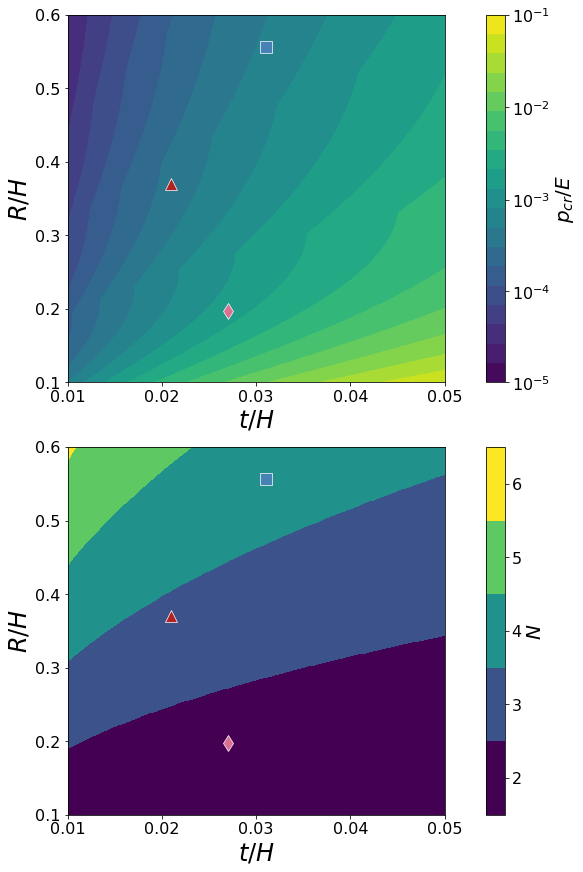

In [26]:
fig, ax = plt.subplots(2,1, figsize = (8,12), constrained_layout = True)

edge_width_all = 0.7
# ax.imshow(res_all)
ax[0].plot(0.031, 0.556, 's', color = 'w', markerfacecolor = color_4folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[0].plot(0.027, 0.197, 'd', color = 'w', markerfacecolor = color_2folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[0].plot(0.021, 0.370, '^', color = 'w', markerfacecolor = color_3folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
num_values = np.unique(n_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')

map_thing = ax[0].contourf(yv, xv, p_cr_all, cmap = 'viridis', levels=np.logspace(-5,-1, 20), norm = LogNorm())



ticks_set = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
ticks_set_power = [int(np.log10(t)) for t in ticks_set]
cbar = fig.colorbar(map_thing, ticks = ticks_set)
cbar.ax.yaxis.set_ticks(ticks_set, labels=[f"$10^{{{val}}}$" for val in ticks_set_power])
cbar.set_label(label = '$p_{cr}/E$', size = fontsize_legend)
cbar.ax.tick_params(labelsize=fontsize_ticks)
cbar.ax.yaxis.offsetText.set_fontsize(fontsize_ticks)

############################

ax[1].plot(0.031, 0.556, 's', color = 'w', markerfacecolor = color_4folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[1].plot(0.027, 0.197, 'd', color = 'w', markerfacecolor = color_2folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
ax[1].plot(0.021, 0.370, '^', color = 'w', markerfacecolor = color_3folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
num_values = np.unique(n_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')
levels_set = np.arange(6) + 1.5
map_thing = ax[1].contourf(yv, xv, n_all, levels = levels_set, cmap = 'viridis', vmin = 2, vmax = 6)



cbar = fig.colorbar(map_thing, ticks=[2,3,4,5,6])
cbar.ax.tick_params(labelsize=fontsize_ticks)
cbar.set_label(label = '$N$', size = fontsize_legend)

for axis in ax:
    axis.set_xlabel('$t/H$', fontsize = fontsize_axes)
    axis.set_ylabel('$R/H$', fontsize = fontsize_axes)
    axis.tick_params(labelsize = fontsize_ticks)
    axis.set_xlim(np.min(v_t_try), np.max(v_t_try))
    axis.set_ylim(np.min(v_R_try), np.max(v_R_try))

fig.savefig(f'{folder_out}/fig1_model_logspace.png', dpi = 300)

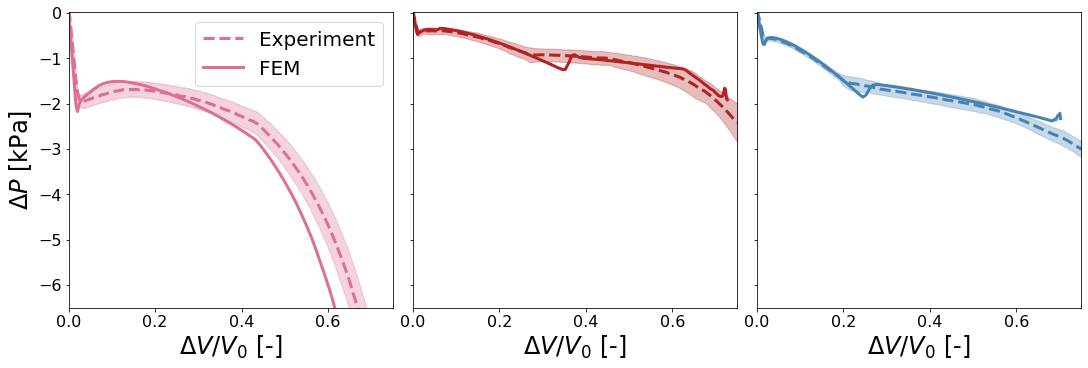

In [17]:
fig, ax = plt.subplots(1,3,figsize = figsize_three, constrained_layout = True, sharey = True)

select_fac = 1

#######################################################

'''load exp 4 folds'''
data_all = np.loadtxt('exp_results/PV_4folds_R10_new.csv', skiprows = 2, delimiter = ',', usecols = tuple(range(6)))
vol_all = data_all[:,0]

pressure_4_mean = np.mean(data_all[:,1:], axis = 1)
pressure_4_exp_std = np.std(data_all[:,1:], axis = 1)

pressure_4_smooth = smooth_pv_data(data_all[:,1:], 300)
pressure_4_smooth_mean = np.mean(pressure_4_smooth, axis = 1)
pressure_4_smooth_std = np.std(pressure_4_smooth, axis = 1)

R = 10 #mm
H = 18 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL
pressure_0 = pressure_4_mean[0]

ax[2].plot((vol_all/vol_0)[::select_fac], pressure_4_smooth_mean[::select_fac], '--', label = 'Experiment: 4 folds', linewidth = linewidth_all, color = color_4folds)
ax[2].fill_between(vol_all/vol_0, pressure_4_smooth_mean + pressure_4_smooth_std, pressure_4_smooth_mean - pressure_4_smooth_std, alpha = 0.3, color = color_4folds)

'''load 4 folds sim data'''

t, E = (0.54, 1.2)
nu = 0.5
data_cur = np.loadtxt(f'data_out/sim-long-4folds-202_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3
ax[2].plot(vol_norm,pressure_kpa, label = 'FEM', color = color_4folds, linewidth = linewidth_all)
np.savez('exp_results/PV_4folds_smoothed', vol_norm = vol_all/vol_0, diff_volume = vol_all, vol_0 = vol_0, pressure_mean = pressure_4_smooth_mean, pressure_std = pressure_4_smooth_std)

###########################################################

'''2 folds exp data'''

data_all = np.loadtxt('exp_results/PV_2folds_R9_1p2.csv', skiprows = 2, delimiter = ',', usecols = tuple(range(7)))
vol_all = data_all[:,0]
pressure_2 = data_all[:,1:]
pressure_2_smooth = smooth_pv_data(pressure_2)
pressure_2_smooth_mean = np.mean(pressure_2_smooth, axis = 1)
pressure_2_smooth_std = np.std(pressure_2_smooth, axis = 1)

R = 8.8 #mm
H = 44.75 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL

ax[0].plot((vol_all/vol_0)[::select_fac], pressure_2_smooth_mean[::select_fac], '--', label = 'Experiment', linewidth = linewidth_all, color = color_2folds)
ax[0].fill_between(vol_all/vol_0, pressure_2_smooth_mean + pressure_2_smooth_std, pressure_2_smooth_mean - pressure_2_smooth_std, alpha = 0.3, color = color_2folds)

'''2 folds sim data'''

E, t = (1.2, 1.2)
data_cur = np.loadtxt(f'data_out/sim-long-2folds-200_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3

ax[0].plot(vol_norm,pressure_kpa, label = 'FEM', color = color_2folds, linewidth = linewidth_all)
np.savez('exp_results/PV_2folds_smoothed', vol_norm = vol_all/vol_0, diff_volume = vol_all, vol_0 = vol_0, pressure_mean = pressure_2_smooth_mean, pressure_std = pressure_2_smooth_std)

#################################################################

'''load 3 folds exp data'''
data_all = np.loadtxt('exp_results/PV_3folds_R10_new.csv', skiprows = 2, delimiter = ',', usecols=(0,1,3,4,5))
vol_all = data_all[:,0]

pressure_3_smooth = smooth_pv_data(data_all[:,1:], 400)
pressure_3_smooth_mean = np.mean(pressure_3_smooth, axis = 1)
pressure_3_smooth_std = np.std(pressure_3_smooth, axis = 1)

R = 10 #mm
H = 27 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL

eps = -0
ax[1].plot((vol_all/vol_0)[::select_fac] + eps, pressure_3_smooth_mean[::select_fac], '--', label = 'Experiment: 3 folds', linewidth = linewidth_all, color = color_3folds)
ax[1].fill_between(vol_all/vol_0 + eps, pressure_3_smooth_mean + pressure_3_smooth_std, pressure_3_smooth_mean - pressure_3_smooth_std, alpha = 0.3, color = color_3folds)

'''load 3 folds sim data'''
t, E = (0.54, 1.2)
#plot nu = 0.5 up to \delta V/V_0 = 0.7 for fitted parameters
nu = 0.5
data_cur = np.loadtxt(f'data_out/sim-long-3folds-201_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3
ax[1].plot(vol_norm,pressure_kpa, label = rf't = {t}mm, E = {E}MPa', color = color_3folds, linewidth = linewidth_all)
np.savez('exp_results/PV_3folds_smoothed', vol_norm = vol_all/vol_0, diff_volume = vol_all, vol_0 = vol_0, pressure_mean = pressure_3_smooth_mean, pressure_std = pressure_3_smooth_std)

############################################################


#set parameters for plot
ax[0].set_ylim(top = 0.01, bottom = -6.5)
ax[0].set_ylabel('$\Delta P$ [kPa]', fontsize = fontsize_axes)
for i in range(len(ax)):
    ax[i].set_xlabel('$\Delta V/V_0$ [-]', fontsize = fontsize_axes)
    ax[i].set_xlim(left = 0, right = 0.75)
    ax[i].tick_params(labelsize = fontsize_ticks)
ax[0].legend(loc = 'best', fontsize = fontsize_legend)

fig.savefig(f'{folder_out}/pv_all.png', dpi = 300)

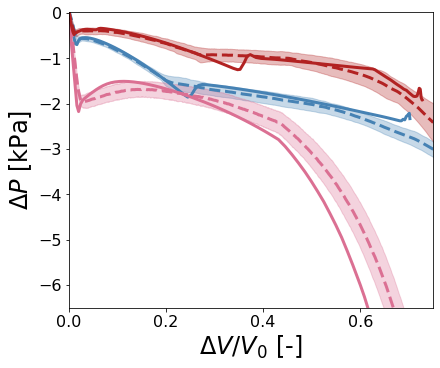

In [16]:
fig, ax = plt.subplots(figsize = figsize_whole, constrained_layout = True)

select_fac = 1

#######################################################

'''load exp 4 folds'''
data_all = np.loadtxt('exp_results/PV_4folds_R10_new.csv', skiprows = 2, delimiter = ',', usecols = tuple(range(6)))
vol_all = data_all[:,0]

pressure_4_mean = np.mean(data_all[:,1:], axis = 1)
pressure_4_exp_std = np.std(data_all[:,1:], axis = 1)

pressure_4_smooth = smooth_pv_data(data_all[:,1:], 300)
pressure_4_smooth_mean = np.mean(pressure_4_smooth, axis = 1)
pressure_4_smooth_std = np.std(pressure_4_smooth, axis = 1)

R = 10 #mm
H = 18 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL
pressure_0 = pressure_4_mean[0]

ax.plot((vol_all/vol_0)[::select_fac], pressure_4_smooth_mean[::select_fac], '--', label = 'Experiment: 4 folds', linewidth = linewidth_all, color = color_4folds)
ax.fill_between(vol_all/vol_0, pressure_4_smooth_mean + pressure_4_smooth_std, pressure_4_smooth_mean - pressure_4_smooth_std, alpha = 0.3, color = color_4folds)

'''load 4 folds sim data'''

t, E = (0.54, 1.2)
nu = 0.5
data_cur = np.loadtxt(f'data_out/sim-long-4folds-202_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3
ax.plot(vol_norm,pressure_kpa, label = 'FEM', color = color_4folds, linewidth = linewidth_all)
np.savez('exp_results/PV_4folds_smoothed', vol_norm = vol_all/vol_0, diff_volume = vol_all, vol_0 = vol_0, pressure_mean = pressure_4_smooth_mean, pressure_std = pressure_4_smooth_std)

###########################################################

'''2 folds exp data'''
data_all = np.loadtxt('exp_results/PV_2folds_R9_1p2.csv', skiprows = 2, delimiter = ',', usecols = tuple(range(7)))
vol_all = data_all[:,0]
pressure_2 = data_all[:,1:]
pressure_2_smooth = smooth_pv_data(pressure_2)
pressure_2_smooth_mean = np.mean(pressure_2_smooth, axis = 1)
pressure_2_smooth_std = np.std(pressure_2_smooth, axis = 1)

R = 8.8 #mm
H = 44.75 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL

ax.plot((vol_all/vol_0)[::select_fac], pressure_2_smooth_mean[::select_fac], '--', label = 'Experiment', linewidth = linewidth_all, color = color_2folds)
ax.fill_between(vol_all/vol_0, pressure_2_smooth_mean + pressure_2_smooth_std, pressure_2_smooth_mean - pressure_2_smooth_std, alpha = 0.3, color = color_2folds)

'''2 folds sim data'''
E, t = (1.2, 1.2)
data_cur = np.loadtxt(f'data_out/sim-long-2folds-200_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3

ax.plot(vol_norm,pressure_kpa, label = 'FEM', color = color_2folds, linewidth = linewidth_all)

#################################################################

'''load 3 folds exp data'''
data_all = np.loadtxt('exp_results/PV_3folds_R10_new.csv', skiprows = 2, delimiter = ',', usecols=(0,1,3,4,5))
vol_all = data_all[:,0]

pressure_3_smooth = smooth_pv_data(data_all[:,1:], 400)
pressure_3_smooth_mean = np.mean(pressure_3_smooth, axis = 1)
pressure_3_smooth_std = np.std(pressure_3_smooth, axis = 1)

R = 10 #mm
H = 27 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL

eps = -0
ax.plot((vol_all/vol_0)[::select_fac] + eps, pressure_3_smooth_mean[::select_fac], '--', label = 'Experiment: 3 folds', linewidth = linewidth_all, color = color_3folds)
ax.fill_between(vol_all/vol_0 + eps, pressure_3_smooth_mean + pressure_3_smooth_std, pressure_3_smooth_mean - pressure_3_smooth_std, alpha = 0.3, color = color_3folds)

'''load 3 folds sim data'''
t, E = (0.54, 1.2)
#plot nu = 0.5 up to \delta V/V_0 = 0.7 for fitted parameters
nu = 0.5
data_cur = np.loadtxt(f'data_out/sim-long-3folds-201_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3
ax.plot(vol_norm,pressure_kpa, label = rf't = {t}mm, E = {E}MPa', color = color_3folds, linewidth = linewidth_all)

############################################################


#set parameters for plot
ax.set_ylim(top = 0.01, bottom = -6.5)
ax.set_ylabel('$\Delta P$ [kPa]', fontsize = fontsize_axes)
ax.set_xlabel('$\Delta V/V_0$ [-]', fontsize = fontsize_axes)
ax.set_xlim(left = 0, right = 0.75)
ax.tick_params(labelsize = fontsize_ticks)
# ax.legend(loc = 'best', fontsize = fontsize_legend)

fig.savefig(f'{folder_out}/pv_all_one_fig.png', dpi = 300)

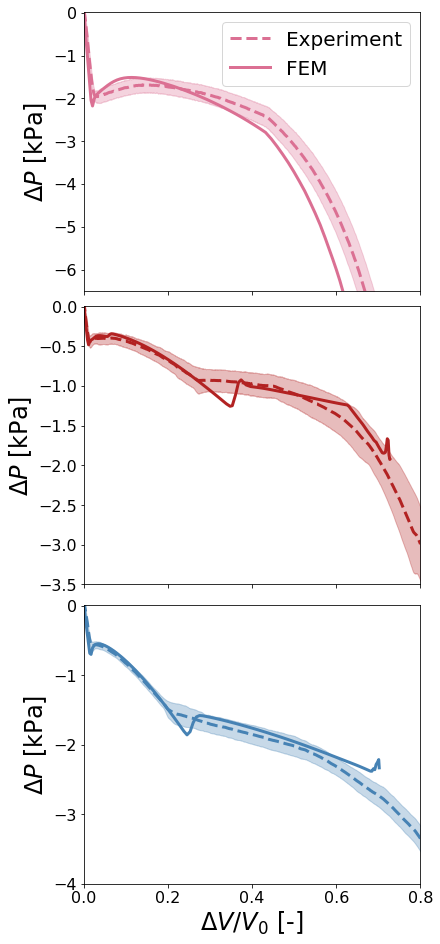

In [15]:
fig, ax = plt.subplots(3,1,figsize = figsize_three_vert, constrained_layout = True, sharex = True)

#######################################################

'''load exp 4 folds'''
data_all = np.loadtxt('exp_results/PV_4folds_R10_new.csv', skiprows = 2, delimiter = ',', usecols = tuple(range(6)))
vol_all = data_all[:,0]

pressure_4_mean = np.mean(data_all[:,1:], axis = 1)
pressure_4_exp_std = np.std(data_all[:,1:], axis = 1)

pressure_4_smooth = smooth_pv_data(data_all[:,1:], 300)
pressure_4_smooth_mean = np.mean(pressure_4_smooth, axis = 1)
pressure_4_smooth_std = np.std(pressure_4_smooth, axis = 1)

R = 10 #mm
H = 18 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL
pressure_0 = pressure_4_mean[0]

ax[2].plot((vol_all/vol_0)[::select_fac], pressure_4_smooth_mean[::select_fac], '--', label = 'Experiment: 4 folds', linewidth = linewidth_all, color = color_4folds)
ax[2].fill_between(vol_all/vol_0, pressure_4_smooth_mean + pressure_4_smooth_std, pressure_4_smooth_mean - pressure_4_smooth_std, alpha = 0.3, color = color_4folds)

'''load 4 folds sim data'''

t, E = (0.54, 1.2)
nu = 0.5
data_cur = np.loadtxt(f'data_out/sim-long-4folds-202_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3
ax[2].plot(vol_norm,pressure_kpa, label = 'FEM', color = color_4folds, linewidth = linewidth_all)
np.savez('exp_results/PV_4folds_smoothed', vol_norm = vol_all/vol_0, diff_volume = vol_all, vol_0 = vol_0, pressure_mean = pressure_4_smooth_mean, pressure_std = pressure_4_smooth_std)

###########################################################

'''2 folds exp data'''

data_all = np.loadtxt('exp_results/PV_2folds_R9_1p2.csv', skiprows = 2, delimiter = ',', usecols = tuple(range(7)))
vol_all = data_all[:,0]
pressure_2 = data_all[:,1:]
pressure_2_smooth = smooth_pv_data(pressure_2)
pressure_2_smooth_mean = np.mean(pressure_2_smooth, axis = 1)
pressure_2_smooth_std = np.std(pressure_2_smooth, axis = 1)

R = 8.8 #mm
H = 44.75 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL

ax[0].plot((vol_all/vol_0)[::select_fac], pressure_2_smooth_mean[::select_fac], '--', label = 'Experiment', linewidth = linewidth_all, color = color_2folds)
ax[0].fill_between(vol_all/vol_0, pressure_2_smooth_mean + pressure_2_smooth_std, pressure_2_smooth_mean - pressure_2_smooth_std, alpha = 0.3, color = color_2folds)

'''2 folds sim data'''
E, t = (1.2, 1.2)
data_cur = np.loadtxt(f'data_out/sim-long-2folds-200_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3

ax[0].plot(vol_norm,pressure_kpa, label = 'FEM', color = color_2folds, linewidth = linewidth_all)
np.savez('exp_results/PV_2folds_smoothed', vol_norm = vol_all/vol_0, diff_volume = vol_all, vol_0 = vol_0, pressure_mean = pressure_2_smooth_mean, pressure_std = pressure_2_smooth_std)

#################################################################

'''load 3 folds exp data'''
data_all = np.loadtxt('exp_results/PV_3folds_R10_new.csv', skiprows = 2, delimiter = ',', usecols=(0,1,3,4,5))
vol_all = data_all[:,0]

pressure_3_smooth = smooth_pv_data(data_all[:,1:], 400)
pressure_3_smooth_mean = np.mean(pressure_3_smooth, axis = 1)
pressure_3_smooth_std = np.std(pressure_3_smooth, axis = 1)

R = 10 #mm
H = 27 #mm
vol_0 = np.pi * R * R * H * 1e-3 #mm^3 * 1000 should be cm^3 aka mL

eps = -0
ax[1].plot((vol_all/vol_0)[::select_fac] + eps, pressure_3_smooth_mean[::select_fac], '--', label = 'Experiment: 3 folds', linewidth = linewidth_all, color = color_3folds)
ax[1].fill_between(vol_all/vol_0 + eps, pressure_3_smooth_mean + pressure_3_smooth_std, pressure_3_smooth_mean - pressure_3_smooth_std, alpha = 0.3, color = color_3folds)

'''load 3 folds sim data'''
t, E = (0.54, 1.2)
#plot nu = 0.5 up to \delta V/V_0 = 0.7 for fitted parameters
nu = 0.5
data_cur = np.loadtxt(f'data_out/sim-long-3folds-201_pcav_cvol.txt')
vol_norm = -(data_cur[:,0] - data_cur[0,0])/data_cur[0,0]
pressure_kpa = data_cur[:,1] * 1e3
ax[1].plot(vol_norm,pressure_kpa, label = rf't = {t}mm, E = {E}MPa', color = color_3folds, linewidth = linewidth_all)
np.savez('exp_results/PV_3folds_smoothed', vol_norm = vol_all/vol_0, diff_volume = vol_all, vol_0 = vol_0, pressure_mean = pressure_3_smooth_mean, pressure_std = pressure_3_smooth_std)

############################################################


#set parameters for plot
ax[0].set_ylim(top = 0.01, bottom = -6.5)
ax[2].set_xlabel('$\Delta V/V_0$ [-]', fontsize = fontsize_axes)
for i in range(len(ax)):
    ax[i].set_xlim(left = 0, right = 0.8)
    ax[i].tick_params(labelsize = fontsize_ticks)
    ax[i].set_ylim(top = 0.01)
    ax[i].set_ylabel('$\Delta P$ [kPa]', fontsize = fontsize_axes)
ax[0].set_ylim(bottom = -6.5)
ax[1].set_ylim(bottom = -3.5)
ax[2].set_ylim(bottom = -4)
ax[0].legend(loc = 'best', fontsize = fontsize_legend)

fig.savefig(f'{folder_out}/pv_all_vert.png', dpi = 300)

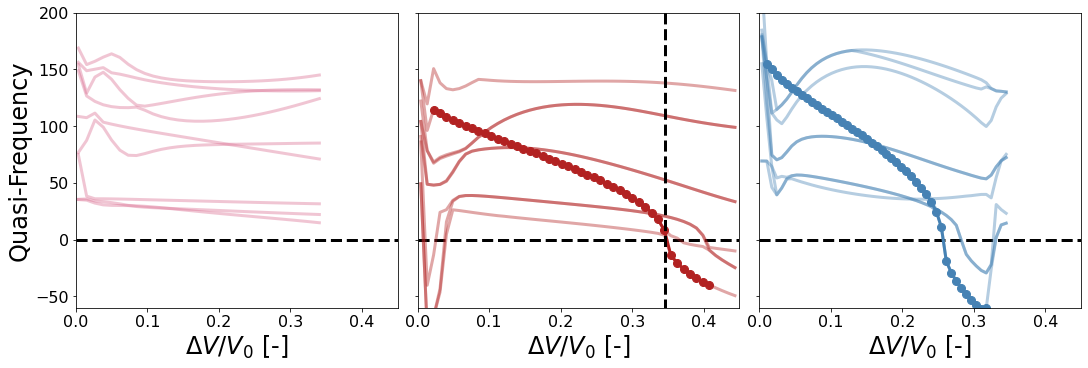

In [11]:
fig, ax = plt.subplots(1,3,figsize = figsize_three, constrained_layout = True, sharey = True)

for axis in ax: axis.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

alpha_all = 0.4

########################################
'''4 folds freq'''
idx_4 = 265
nu = 0.5
idx_plot = 2
color_plot = 'firebrick'

data_path = f'data_out/4fold-test_nu-{idx_4}_eig_val.txt'
data_cur = np.loadtxt(data_path)
temp_all = data_cur[:,0]
freq_all = data_cur[:,1:]

initial_i = [1,2]
initial_j = [8,8]

for j in range(np.shape(freq_all)[1]-1):
    freq_rescale = rescale_eigenvalue(freq_all[:,j])
    # ax[idx_plot].plot(-3*temp_all, freq_rescale, 'o', color = color_plot, markersize = markersize_all)
    ax[idx_plot].plot(-3*temp_all, freq_rescale, '-', color = color_4folds,
        linewidth = linewidth_all, alpha = alpha_all)

num_samp = np.shape(freq_all)[0] - initial_i[-1] - 3
i_all, j_all, cut_idx = highlight_mode(freq_all, initial_i, initial_j, num_samp)
ax[idx_plot].plot(-3*temp_all[i_all[cut_idx]], rescale_eigenvalue(freq_all[i_all[cut_idx],j_all[cut_idx]]), '-o', color = color_4folds, markersize = markersize_all, linewidth = linewidth_all)

ylim_cur = ax[idx_plot].get_ylim()
f = lambda x: np.interp(x,-3*temp_all,freq_all[:,0])
sol_root = root(f,0.25)
# ax[idx_plot].vlines(float(sol_root.x),ylim_cur[0], ylim_cur[1], 'black', '--', linewidth = linewidth_all, label = '$\lambda = 0$')

########################################

'''2 folds freq'''
idx_2 = 305
nu = 0.5
idx_plot = 0

data_path = f'data_out/2fold-test_nu-{idx_2}_eig_val.txt'
data_cur = np.loadtxt(data_path)
temp_all = data_cur[:,0]
freq_all = data_cur[:,1:]

for j in range(np.shape(freq_all)[1]-1):
    freq_rescale = rescale_eigenvalue(freq_all[:,j])
    # ax[idx_plot].plot(-3*temp_all, freq_rescale, 'o', color = color_plot, markersize = markersize_all)
    ax[idx_plot].plot(-3*temp_all, freq_rescale, '-', color = color_2folds, linewidth = linewidth_all, alpha = alpha_all)

########################################

'''3 folds freq'''
idx_3 = 675
nu = 0.45
idx_plot = 1

initial_i = [2,3]
initial_j = [7,7]

data_path = f'data_out/3fold-test_nu-{idx_3}_eig_val.txt'
data_cur = np.loadtxt(data_path)
temp_all = data_cur[:,0]
freq_all = data_cur[:,1:]

for j in range(np.shape(freq_all)[1]-1):
    freq_rescale = rescale_eigenvalue(freq_all[:,j])
    # ax[idx_plot].plot(-3*temp_all, freq_rescale, 'o', color = color_plot, markersize = markersize_all)
    ax[idx_plot].plot(-3*temp_all, freq_rescale, '-', color = color_3folds, linewidth = linewidth_all, alpha = alpha_all)

num_samp = np.shape(freq_all)[0] - initial_i[-1] - 3
i_all, j_all, cut_idx = highlight_mode(freq_all, initial_i, initial_j, num_samp)
ax[idx_plot].plot(-3*temp_all[i_all[cut_idx]], rescale_eigenvalue(freq_all[i_all[cut_idx],j_all[cut_idx]]), '-o', color = color_3folds, markersize = markersize_all, linewidth = linewidth_all)

f = lambda x: np.interp(x,-3*temp_all,freq_all[:,0])
sol_root = root(f,0.35)
ax[idx_plot].vlines(float(sol_root.x),ylim_cur[0], ylim_cur[1], 'black', '--', linewidth = linewidth_all, label = '$\lambda = 0$')

ax[0].set_ylabel('Quasi-Frequency', fontsize = fontsize_axes)
ax[0].set_ylim(top = 200, bottom = -60)
for axis in ax:
    axis.set_xlabel('$\Delta V/V_0$ [-]', fontsize = fontsize_axes)
    axis.tick_params(labelsize = fontsize_ticks)
    axis.set_xlim(0,0.45)


fig.savefig(f'{folder_out}/freq_all.jpg', dpi = 300)


4folds 0 freq: 0.256


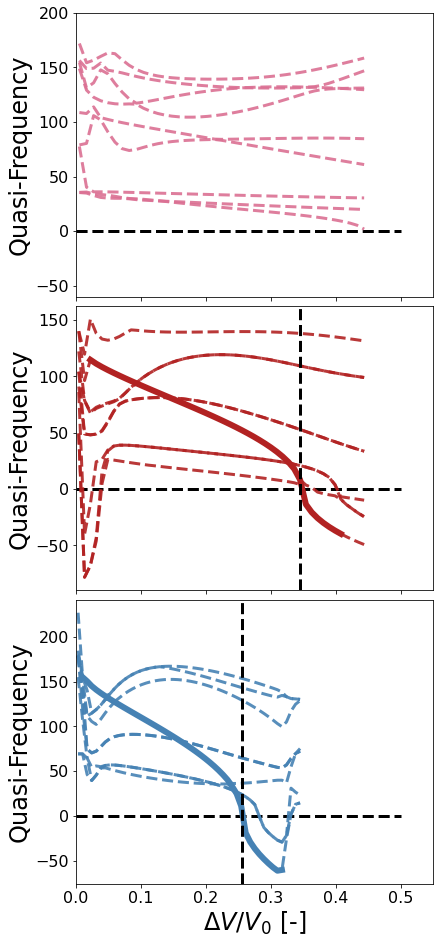

In [50]:
fig, ax = plt.subplots(3,1,figsize = figsize_three_vert, constrained_layout = True, sharex = True)

for axis in ax: axis.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

alpha_all = 0.9
extra_thickness = 3

########################################
'''4 folds freq'''
idx_4 = 265
nu = 0.5
idx_plot = 2
color_plot = 'firebrick'

data_path = f'data_out/4fold-test_nu-{idx_4}_eig_val.txt'
data_cur = np.loadtxt(data_path)
temp_all = data_cur[:,0]
freq_all = data_cur[:,1:]

initial_i = [1,2]
initial_j = [8,8]

for j in range(np.shape(freq_all)[1]-1):
    freq_rescale = rescale_eigenvalue(freq_all[:,j])
    # ax[idx_plot].plot(-3*temp_all, freq_rescale, 'o', color = color_plot, markersize = markersize_all)
    ax[idx_plot].plot(-3*temp_all, freq_rescale, '--', color = color_4folds,
        linewidth = linewidth_all, alpha = alpha_all)

num_samp = np.shape(freq_all)[0] - initial_i[-1] - 3
i_all, j_all, cut_idx = highlight_mode(freq_all, initial_i, initial_j, num_samp)
ax[idx_plot].plot(-3*temp_all[i_all[cut_idx]], rescale_eigenvalue(freq_all[i_all[cut_idx],j_all[cut_idx]]), '-',
                  color = color_4folds, markersize = markersize_all, linewidth = linewidth_all + extra_thickness)

ylim_cur = ax[idx_plot].get_ylim()
f = lambda x: np.interp(x,-3*temp_all,freq_all[:,0])
sol_root = root(f,0.25)
print(f'4folds 0 freq: {float(sol_root.x):.3f}')
ax[idx_plot].vlines(float(sol_root.x),ylim_cur[0], ylim_cur[1], 'black', '--', linewidth = linewidth_all, label = '$\lambda = 0$')
ax[idx_plot].set_ylim(ylim_cur)

########################################

'''2 folds freq'''
idx_2 = 110
nu = 0.5
idx_plot = 0

data_path = f'data_out/sim-long-2folds-{idx_2}_eig_val.txt'
# data_path = f'data_out/2fold-test_nu-{idx_2}_eig_val.txt'
data_cur = np.loadtxt(data_path)
temp_all = data_cur[:,0]
freq_all = data_cur[:,1:]

for j in range(np.shape(freq_all)[1]-1):
    freq_rescale = rescale_eigenvalue(freq_all[:,j])
    # ax[idx_plot].plot(-3*temp_all, freq_rescale, 'o', color = color_plot, markersize = markersize_all)
    ax[idx_plot].plot(-3*temp_all, freq_rescale, '--', color = color_2folds, linewidth = linewidth_all, alpha = alpha_all)

########################################

'''3 folds freq'''
idx_3 = 675
nu = 0.45
idx_plot = 1

initial_i = [2,3]
initial_j = [7,7]

data_path = f'data_out/3fold-test_nu-{idx_3}_eig_val.txt'
data_cur = np.loadtxt(data_path)
temp_all = data_cur[:,0]
freq_all = data_cur[:,1:]

for j in range(np.shape(freq_all)[1]-1):
    freq_rescale = rescale_eigenvalue(freq_all[:,j])
    # ax[idx_plot].plot(-3*temp_all, freq_rescale, 'o', color = color_plot, markersize = markersize_all)
    ax[idx_plot].plot(-3*temp_all, freq_rescale, '--', color = color_3folds, linewidth = linewidth_all, alpha = alpha_all)

num_samp = np.shape(freq_all)[0] - initial_i[-1] - 3
i_all, j_all, cut_idx = highlight_mode(freq_all, initial_i, initial_j, num_samp)
ax[idx_plot].plot(-3*temp_all[i_all[cut_idx]], rescale_eigenvalue(freq_all[i_all[cut_idx],j_all[cut_idx]]), '-',
                  color = color_3folds, markersize = markersize_all, linewidth = linewidth_all + extra_thickness)

ylim_cur = ax[idx_plot].get_ylim()
f = lambda x: np.interp(x,-3*temp_all,freq_all[:,0])
sol_root = root(f,0.35)
ax[idx_plot].vlines(float(sol_root.x),ylim_cur[0], ylim_cur[1], 'black', '--', linewidth = linewidth_all, label = '$\lambda = 0$')
ax[idx_plot].set_ylim(ylim_cur)


ax[2].set_xlabel('$\Delta V/V_0$ [-]', fontsize = fontsize_axes)
ax[0].set_ylim(top = 200, bottom = -60)
for axis in ax:
    axis.set_ylabel('Quasi-Frequency', fontsize = fontsize_axes)
    axis.tick_params(labelsize = fontsize_ticks)
    axis.set_xlim(0,0.55)


fig.savefig(f'{folder_out}/freq_all_vert.jpg', dpi = 300)


array([[<AxesSubplot: ylabel='Contraction [-]'>, <AxesSubplot: >],
       [<AxesSubplot: xlabel='$\\Delta V/V_0$ [-]', ylabel='Twist $\\phi$ [deg]'>,
        <AxesSubplot: xlabel='$-\\Delta P$ [kPa]'>]], dtype=object)

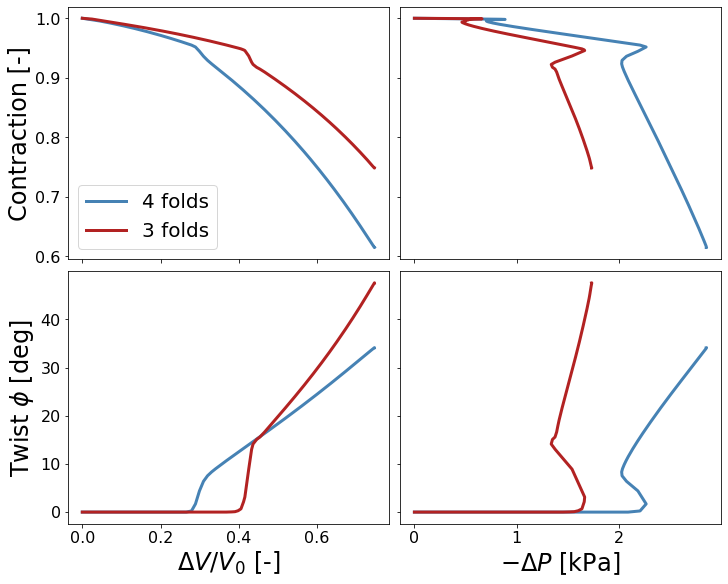

In [96]:
fig, ax = plt.subplots(2,2,figsize = (10,8), constrained_layout = True, sharey = 'row', sharex = 'col')

'''4 folds'''
idx_cur = 109
folds_num = 4
contraction_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_contraction_twist.txt'
pv_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_pcav_cvol.txt'


t_all, contraction_all, twist_all = np.loadtxt(contraction_path, unpack = True)
vol_all, pressure_mpa = np.loadtxt(pv_path, unpack = True)
twist_deg = twist_all * 180/np.pi
vol_norm = -(vol_all - vol_all[0])/vol_all[0]
pressure_kpa = pressure_mpa * 1e3


ax[0,0].plot(vol_norm, contraction_all, linewidth = linewidth_all, label = '4 folds', color = color_4folds)
ax[1,0].plot(vol_norm, twist_deg, linewidth = linewidth_all, color = color_4folds)
ax[0,1].plot(-pressure_kpa, contraction_all, linewidth = linewidth_all, color = color_4folds)
ax[1,1].plot(-pressure_kpa, twist_deg, linewidth = linewidth_all, color = color_4folds)


##########################################################
'''4 folds'''
idx_cur = 108
folds_num = 3
contraction_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_contraction_twist.txt'
pv_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_pcav_cvol.txt'


t_all, contraction_all, twist_all = np.loadtxt(contraction_path, unpack = True)
vol_all, pressure_mpa = np.loadtxt(pv_path, unpack = True)
twist_deg = twist_all * 180/np.pi
vol_norm = -(vol_all - vol_all[0])/vol_all[0]
pressure_kpa = pressure_mpa * 1e3

ax[0,0].plot(vol_norm, contraction_all, linewidth = linewidth_all, label = '3 folds', color = color_3folds)
ax[1,0].plot(vol_norm, twist_deg, linewidth = linewidth_all, color = color_3folds)
ax[0,1].plot(-pressure_kpa, contraction_all, linewidth = linewidth_all, color = color_3folds)
ax[1,1].plot(-pressure_kpa, twist_deg, linewidth = linewidth_all, color = color_3folds)

#######################################

ax[1,0].set_xlabel('$\Delta V/V_0$ [-]', fontsize = fontsize_axes)
ax[1,1].set_xlabel('$-\Delta P$ [kPa]', fontsize = fontsize_axes)

ax[0,0].set_ylabel('Contraction [-]', fontsize = fontsize_axes)
ax[1,0].set_ylabel('Twist $\phi$ [deg]', fontsize = fontsize_axes)

ax[0,0].legend(loc = 'best', fontsize = fontsize_legend)

for axis in np.ndarray.flatten(ax):
    axis.tick_params(labelsize = fontsize_ticks)
ax


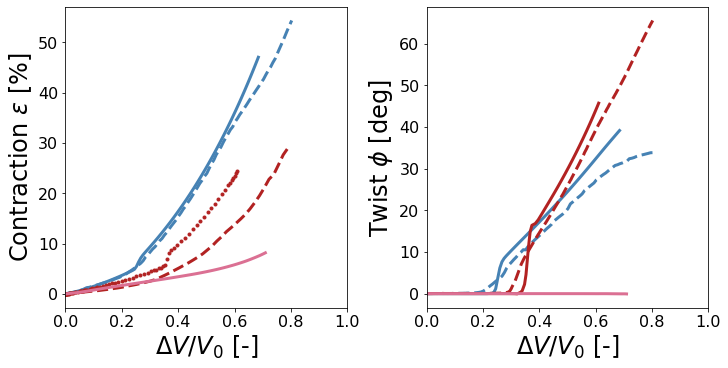

In [27]:
fig, ax = plt.subplots(1,2,figsize = figsize_two, constrained_layout = True)


'''4 folds exp'''
exp_data = np.loadtxt('exp_results/DV_4f_Exp_Updated.csv', skiprows = 1, delimiter=',')
vol_norm = exp_data[:,0]
twist_mean = np.mean(exp_data[:,1:4], axis = 1)
contraction_mean = 100*np.mean(exp_data[:,4:7], axis = 1)

ax[0].plot(vol_norm, contraction_mean, '--', linewidth = linewidth_all, label = '4 folds exp', color = color_4folds)
ax[1].plot(vol_norm, twist_mean, '--', linewidth = linewidth_all, color = color_4folds)


##########################################################
'''4 folds sim'''
end_idx = -6
idx_cur = 202
folds_num = 4
contraction_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_contraction_twist.txt'
pv_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_pcav_cvol.txt'
props_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_props.txt'

#[self.H, self.R, self.t1, self.t2, self.theta, self.w, self.E1, self.E2, self.E_cap, self.h_element]

t_all, contraction_all, twist_all = np.loadtxt(contraction_path, unpack = True)
vol_all, pressure_mpa = np.loadtxt(pv_path, unpack = True)
twist_deg = twist_all * 180/np.pi
vol_norm = -(vol_all - vol_all[0])/vol_all[0]
pressure_kpa = pressure_mpa * 1e3
contraction_strain = 1 - contraction_all


ax[0].plot(vol_norm[:end_idx], contraction_strain[:end_idx]*100, linewidth = linewidth_all, label = '4 folds FEM', color = color_4folds)
ax[1].plot(vol_norm[:end_idx], twist_deg[:end_idx], linewidth = linewidth_all, color = color_4folds)
##########################################################
'''3 folds exp'''
select_fac = 8
exp_data = np.loadtxt('exp_results/DV_3f_Exp.csv', skiprows = 1, delimiter=',')
vol_norm = exp_data[:,0]
twist_mean = np.mean(exp_data[:,1:4], axis = 1)
contraction_mean = 100*np.mean(exp_data[:,4:7], axis = 1)

ax[0].plot(vol_norm[::select_fac], contraction_mean[::select_fac], '--', linewidth = linewidth_all, label = '3 folds exp', color = color_3folds)
ax[1].plot(vol_norm, twist_mean, '--', linewidth = linewidth_all, color = color_3folds)

##########################################################
'''3 folds sim'''
end_idx = -34 #-7
idx_cur = 201
folds_num = 3
contraction_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_contraction_twist.txt'
pv_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_pcav_cvol.txt'


t_all, contraction_all, twist_all = np.loadtxt(contraction_path, unpack = True)
vol_all, pressure_mpa = np.loadtxt(pv_path, unpack = True)
twist_deg = -twist_all * 180/np.pi
vol_norm = -(vol_all - vol_all[0])/vol_all[0]
pressure_kpa = pressure_mpa * 1e3
contraction_strain = 1 - contraction_all

ax[0].plot(vol_norm[:end_idx], contraction_strain[:end_idx]*100, linewidth = linewidth_all, label = '3 folds FEM', color = color_3folds)
ax[1].plot(vol_norm[:end_idx], twist_deg[:end_idx], linewidth = linewidth_all, color = color_3folds)


#######################################
'''2 folds sim'''
end_idx = -38
idx_cur = 200
folds_num = 2
contraction_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_contraction_twist.txt'
pv_path = f'data_out/sim-long-{folds_num}folds-{idx_cur}_pcav_cvol.txt'


t_all, contraction_all, twist_all = np.loadtxt(contraction_path, unpack = True)
vol_all, pressure_mpa = np.loadtxt(pv_path, unpack = True)
twist_deg = twist_all * 180/np.pi
vol_norm = -(vol_all - vol_all[0])/vol_all[0]
pressure_kpa = pressure_mpa * 1e3
contraction_strain = 1 - contraction_all

ax[0].plot(vol_norm[:end_idx], contraction_strain[:end_idx]*100, linewidth = linewidth_all, label = '2 folds FEM', color = color_2folds)
ax[1].plot(vol_norm[:end_idx], twist_deg[:end_idx], linewidth = linewidth_all, color = color_2folds)


#######################################



ax[0].set_ylabel(r'Contraction $\varepsilon$ [%]', fontsize = fontsize_axes)
# ax[1].yaxis.tick_right()
# ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel('Twist $\phi$ [deg]', fontsize = fontsize_axes)

# ax[0].legend(loc = 'best', fontsize = fontsize_legend)

for axis in np.ndarray.flatten(ax):
    axis.tick_params(labelsize = fontsize_ticks)
    axis.set_xlabel('$\Delta V/V_0$ [-]', fontsize = fontsize_axes)
    axis.set_xlim(0,1)

fig.savefig(f'{folder_out}/twist_cont_4_3.png', dpi = 300)

